In [1]:
# Using the trained model for prediction
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
from libraries.utils import get_paths, read_traces, read_json, mapint2var, is_consistent

In [2]:
# Configuration
CODE = 'theft_protection'               ### application (code) theft_protection, mamba2, lora_ducy
BEHAVIOUR_FAULTY = 'faulty_data'        ### normal, faulty_data
BEHAVIOUR_NORMAL = 'normal'             ### normal, faulty_data
THREAD = 'single'                       ### single, multi
VER = 3                                 ### format of data collection

base_dir = './trace_data'              ### can be replaced with 'csv', 'exe_plot', 'histogram'
normalbase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = base_dir+f'/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print("Normal base path:", normalbase_path)
print("Faulty base path:", faultybase_path)

Normal base path: ./trace_data/theft_protection/single_thread/version_3/normal
Faulty base path: ./trace_data/theft_protection/single_thread/version_3/faulty_data


In [3]:
train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = [os.path.join(normalbase_path, x) for x in os.listdir(normalbase_path) if 'varlist' in x]

######### get paths #######################
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

test_data_path = paths_traces
test_label_path = paths_label

In [4]:
# Check consistency
if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]] + varlist_path)
    if check_con:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)

sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]

varlist 1 is consistent with varlist 0
varlist 2 is consistent with varlist 0
varlist 3 is consistent with varlist 0


In [5]:
test_data_path

['./trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial1.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial2.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data\\trace_trial3.json']

In [6]:
# prediction for test data
from libraries.anomaly_detection import test_single_id, merge_detections, get_correct_detections
from tensorflow.keras.models import load_model
import joblib

scaler = joblib.load('./scalers/scaler_lstm_id.pkl')  # Load the trained scaler

## checking the detections against the ground truth
DIFF_VAL = 0 
all_detections = []         # To store detections for each file
y_pred_all = []             # To store the predicted labels
y_true_all = []             # To store the ground truth labels
all_tp = []                 # To store all true positives
all_fp = []                 # To store all false positives
all_fn = []                 # To store all false negatives
all_gt = []                 # To store the ground truth

model = load_model('./trained_models/lstm_id_alone_model.keras')  # Load the trained model
sequence_length = 10                                                # Sequence length for the model

# Iterating through each test data file and label file
for test_data, test_label in zip(test_data_path, test_label_path):
    detection, inference_time = test_single_id(test_data, model, sequence_length, scaler)            # Detecting anomalies in the test data
    print("Detection : ", detection)

    print("Detection : ", detection)
    print("len(detection) : ", len(detection))

    all_detections.append((test_data, detection, test_label))
    merge_detection, agg_ts = merge_detections(detection, diff_val=DIFF_VAL)

    print("Merge detection : ", merge_detection)
    
    ground_truth_raw = read_traces(test_label)                                               # read ground truth labels from the label file
    ground_truth = ground_truth_raw['labels']                                                # extract labels from dictionary from ground truth data

    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]

    correct_pred, rest_pred, y_pred, y_true, false_neg = get_correct_detections(merge_detection, ground_truth)  # Comparing detected anomaly with ground truth

    y_pred_all.extend(y_pred)          # predicted labels
    y_true_all.extend(y_true)          # actual ground truth labels
    all_tp.append((test_data, correct_pred, test_label))
    all_fp.append((test_data, rest_pred, test_label))
    all_fn.append((test_data, false_neg, test_label))
    all_gt.append((test_data, ground_truth, test_label))

    print("Inference time : ", (inference_time/32))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
predictions : [[ 7]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 7]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 8]
 [ 7]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 7]
 [ 9]
 [13]
 [ 9]
 [ 9]
 [ 6]
 [ 8]
 [14]
 [ 7]
 [ 8]
 [ 9]
 [ 8]
 [ 7]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [ 8]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 9]
 [13]
 [ 9]
 [ 9]
 [ 6]
 [ 8]
 [ 8]
 [ 7]
 [ 8]
 [14]
 [ 8]
 [ 7]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 7]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 6]
 [ 9]
 [ 7]
 [ 8]
 [ 7]
 [ 9]
 [13]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 8]
 [ 8]
 [ 7]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [14]
 [ 7]
 [ 8]
 [ 9]
 [ 9]
 [ 6]
 [ 8]
 [ 8]
 [ 7]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 8]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 9]
 [ 8]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]
 [ 8]
 [ 8]
 [ 7]
 [ 9]
 [ 8]
 [ 6]
 [ 9]
 [14]
 [ 6]
 [ 9]


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve

y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)

# Calculate evaluation metrics
precision = precision_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2232
Recall: 0.9204
F1 Score: 0.3592


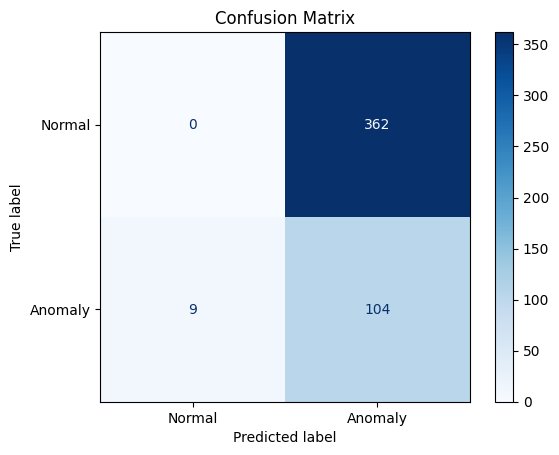

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

conf_matrix = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [9]:
test_label

'./trace_data/theft_protection/single_thread/version_3/faulty_data\\labels\\trace_trial3_labels.json'

In [10]:
# Saving the detections for further analysis

######## save detections for the dashboard to plot #############
import traceback
import json
# DIFF_VAL = 0

for test_data, detections, test_label in all_detections:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', f'lstm_id_detections')
    detection_path = detection_path.replace('lstm_id_detections.json', f'lstm_id_detections_{DIFF_VAL}.json')
    # tp_detection_path = detection_path.replace('ei_detections.json', f'tp_ei_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', f'fp_ei_detections_{DIFF_VAL}.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:
        with open(detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {detection_path}')

            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_tp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'lstm_id_detections')
    tp_detection_path = detection_path.replace('lstm_id_detections.json', f'tp_lstm_id_detections_{DIFF_VAL}.json')
    # fp_detection_path = detection_path.replace('ei_detections.json', 'fp_ei_detections.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(tp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {tp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

for test_data, detections, test_label in all_fp:
    # print(test_data, test_label)
    # print(test_label.replace('labels', 'detections'))
    detection_path = test_label.replace('labels', 'lstm_id_detections')
    # tp_detection_path = detection_path.replace('ei_detections.json', 'tp_ei_detections.json')
    fp_detection_path = detection_path.replace('lstm_id_detections.json', f'fp_lstm_id_detections_{DIFF_VAL}.json')
    # print(detections)

    detection_dir = os.path.dirname(detection_path)
    # print(detection_dir)
    if not os.path.exists(detection_dir):
        os.makedirs(detection_dir)
        print(f'Created Directory: {detection_dir}')

    try:

        with open(fp_detection_path, 'w') as f:
            json.dump(detections, f)
            print(f'Saved detections in {fp_detection_path}')
            
    except Exception as e:
        traceback.print_exception(e)
        print('Error in saving detections')
        continue

Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial1_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial2_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial3_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial1_tp_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial2_tp_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial3_tp_lstm_id_detections_0.json
Saved detections in ./trace_data/theft_protection/single_thread/version_3/faulty_data\lstm_id_detections\trace_trial1_fp_lstm_i